# GAN Theory

>In short, the goal of the **Generative Adversarial Network** (GAN) is too:

$$ 
\begin{split}\begin{align*}
\min_G \max_D V(D,G) &= \mathbb{E}_{\boldsymbol{x}\sim p_{data}}[\log D(\boldsymbol{x})] \\
    & ~~ + \mathbb{E}_{\boldsymbol{z}\sim p_{\boldsymbol{z}}}[\log(1 - D(G(\boldsymbol{z}))]
\end{align*}\end{split}
$$

>Which it does utilizing some real data $\boldsymbol{x}$, some latent vector $\boldsymbol{z}$, the probability of the **discriminator** classifying real data $D(x)$, some fake data generated by the **generator** $G(z)$, and the probability of the discriminator classifying fake data as real $D(G(z))$.

## GAN Components

>Completely though, we require a number of components for our GAN architecture:

$P_{data}$: Samples from training dataset (unknown data distribution)

$P_{z}$: Generator's latent distribution

$P_{g}$: Generated data set (a distribution mapped to $P_{z}$)

$D$: Discriminator

$D.obj() \ \text{or} \ Objective(D)$: Maximize the probability of discerning real from fake data

$G$: Generator

>**Note:** The function that maps samples from $P_z$ to $P_g$: $ P_g = G(P_z)$ with the most optimal solution being $P_g = P_{data}$

$G.obj() \ \text{or} \ Objective(G)$: Minimize the probability from discerning/generate real from data

$\boldsymbol{x}$: real data sample from $P_{data}$

$\boldsymbol{z}$: latent vector

$D(\boldsymbol{x})$: Probability of classifying real data as real

$G(\boldsymbol{z})$: fake data (i.e., $P_g$)

$D(G(\boldsymbol{z}))$: probability of discriminator classifying fake data as real

>The two networks are trained iteratively, each with a separate loss function to be minimized:

$y$: binary label for real ($y=1$) or fake ($y=0$) data. 

$$ 
L_D = - [y \cdot \log(D(x))] + (1-y) \cdot \log(1-D(G(z)))]
$$

$$ 
L_G = - [(1-y) \cdot \log(1-D(G(z)))]
$$

$$
L_G = -1[(1-y) \cdot \log(D(G(z)))]
$$

## GAN Practice
> Alright, but let's actually build a GAN...a quantum GAN. Practically, we'll implement the discriminator as some feedforward artificial neural network (ANN) with task of classification. For the generator, we'll implement using the patch method.

### Module Import

In [6]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Data

In [7]:
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, csv_file, label=0, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.csv_file)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, 0

#### Dataloader Instance

In [8]:
image_size = 8  # Height / width of the square images
batch_size = 1

transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset(
    csv_file="quantum_gans/optdigits.tra", transform=transform)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

#### Visualize

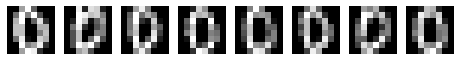

In [9]:
plt.figure(figsize=(8, 2))

for i in range(8):
    image = dataset[i][0].reshape(image_size, image_size)
    plt.subplot(1, 8, i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()

### Implementation of Discriminator

>We can use a fully connected neural network with two hidden layers. A single output will represent the probability of an input being classified as real. 

In [16]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (#features = 64)
            nn.Linear(image_size * image_size, 64),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(64, 16),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

### Implementing the Generator

>The generator $G(z)$ is composed of a sum of sub generators $G^{(i)}$:

$$G(z) = \sum_n G^{(n)}$$

>Alright, so this is probably going to be the most complicated part of this build. Each of these sub generators share the same quantum circuit architecture. 

>The overall quantum generator consists of $N_G$ sub generators, each consisting of $N$ qubits. Anyways, the process from $\boldsymbol{z}$ to $G(z)$ can be broken up into 4 parts: state embedding, parameterisation, non-linear transformation, and post-processing. 

#### State Embedding

>The latent vector $\boldsymbol{z} \in \mathbb{R}^N$ is sampled from a uniform distribution in the interval $[0, \pi/2)$. All the sub generators get the same $\boldsymbol{z}$ which is then embedded using RY gates.

#### Parameterisation

>The parameterized RY gates followed by control Z gates. This layer is repeated $D$ times in total

#### Non-linear Transformation

>We need to get non-linear transformation mappings between $\boldsymbol{z}$ and $P_z$. This is accomplished with "ancillary" qubits. 
>
> For a given sub generator, the pre-measurement quantum state is given by:

$$\ket{\Psi(z)} = U_{G}(\theta)\ket{\boldsymbol{z}}$$

$\ket{\Psi} = \alpha \ket{0} + \beta \ket{1} $: Single qubit

$U_{G}(\theta)$: overall unitary of the parameterized layers

$\Pi:$ a partial measurement
>**Note**$:\Pi = (\ket{0}\bra{0})^{\otimes N_A}$

$\mathcal{A}$: ancillary subsystem

$\rho(\boldsymbol{z})$: post-measurement state
>**Note**: This is dependent on $\boldsymbol{z}$ in both the numerator and denominator. And hence, a non-linear transformation has occurred.

$$
\dfrac{\text{Tr}_{\mathcal{A}}(\Pi \otimes \mathbb{I}\ket{\Psi(\boldsymbol{z})}\bra{\Psi(\boldsymbol{z})})}{\bra{\Psi(\boldsymbol{z})}\Pi \otimes \mathbb{I}\ket{\Psi(\boldsymbol{z})}}
$$

>Alright, then with the other three qubits we will measure the probability of $\rho(\boldsymbol{z})$ in each computational basis state, $P(j)$, to obtain the sub generator output:

$$
\boldsymbol{g}^{(i)} = [P(0), P(1), \ ...  \ ,P(2^{N-N_A - 1})]
$$

#### Post-processing

> So because it turns out that all the elements in $\boldsymbol{g}^{(i)}$ need to sum to 1, we apply a post-processing technique to each patch:

$$
\boldsymbol{\tilde{x}^{(i)}} = \dfrac{\boldsymbol{g}^{(i)}}{\max_k\boldsymbol{g}_k^{(i)}}
$$

> And then the completely generated image is:

$$
\boldsymbol{\tilde{x}^{(i)}} = [\boldsymbol{\tilde{x}^{(1)}}, \ ... \ ,\boldsymbol{\tilde{x}^{(N_G)}}] 
$$

### Okay, let's get Quantum doe

In [18]:
# Quantum variables
n_qubits = 5  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 4  # Number of subgenerators for the patch method / N_G

>Okay, we actually need to define the quantum device that this machine learning computation with run on

In [19]:
# Quantum simulator
dev = qml.device("lightning.qubit", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

> Defining the quantum circuit that the GAN computation will run on

In [21]:
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))

# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532

def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven


> Dang, it's time to actually code the generator doe...

In [22]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth *
                             n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images


### Training

> Time to setup the training pipeline

> Learning rates and number of iterations for the training process

In [23]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 500  # Number of training iterations


### Run Simulation

> Now, we can run the complete forward pass and training process

In [24]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
results = []

while True:
    for i, (data, _) in enumerate(dataloader):

        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1

        # Show loss values
        if counter % 10 == 0:
            print(
                f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            test_images = generator(fixed_noise).view(
                8, 1, image_size, image_size).cpu().detach()

            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)

        if counter == num_iter:
            break
    if counter == num_iter:
        break


Iteration: 10, Discriminator Loss: 1.356, Generator Loss: 0.597
Iteration: 20, Discriminator Loss: 1.325, Generator Loss: 0.621
Iteration: 30, Discriminator Loss: 1.333, Generator Loss: 0.615
Iteration: 40, Discriminator Loss: 1.304, Generator Loss: 0.633
Iteration: 50, Discriminator Loss: 1.275, Generator Loss: 0.648
Iteration: 60, Discriminator Loss: 1.222, Generator Loss: 0.670
Iteration: 70, Discriminator Loss: 1.267, Generator Loss: 0.627
Iteration: 80, Discriminator Loss: 1.253, Generator Loss: 0.647
Iteration: 90, Discriminator Loss: 1.256, Generator Loss: 0.624
Iteration: 100, Discriminator Loss: 1.249, Generator Loss: 0.627
Iteration: 110, Discriminator Loss: 1.177, Generator Loss: 0.660
Iteration: 120, Discriminator Loss: 1.175, Generator Loss: 0.633
Iteration: 130, Discriminator Loss: 1.210, Generator Loss: 0.664
Iteration: 140, Discriminator Loss: 1.231, Generator Loss: 0.605
Iteration: 150, Discriminator Loss: 1.252, Generator Loss: 0.606
Iteration: 160, Discriminator Loss

### Demo Results



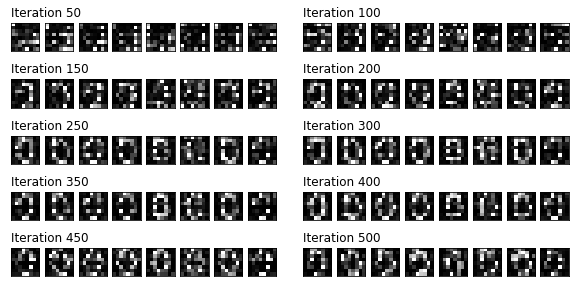

In [25]:
fig = plt.figure(figsize=(10, 5))
outer = gridspec.GridSpec(5, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()